In [162]:
#  Testing in which order the intersections are returned
import shapely
import shapely.plotting
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

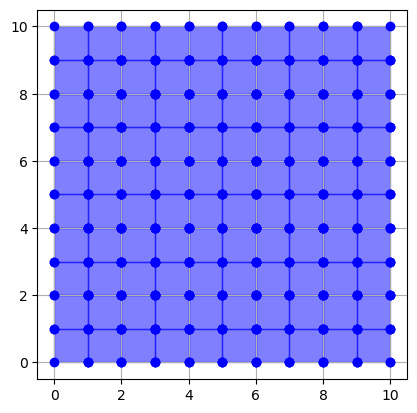

In [163]:
x_min = 0
x_max = 10
y_min = 0
y_max = 10

resolution = 1

x = np.arange(x_min, x_max + resolution, resolution)
y = np.arange(y_min, y_max + resolution, resolution)


cells = []
for i in range(len(x) - 1):
    for j in range(len(y) - 1):
        cell = shapely.geometry.box(x[i], y[j], x[i + 1], y[j + 1])
        cells.append(cell)

for cell in cells:
    shapely.plotting.plot_polygon(cell, color="blue", alpha=0.5)

tree = shapely.STRtree(cells)

In [164]:
def generate_ray(
    offset_from_center, line_angle, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max
):
    """Generates a ray an angle `line_angle` that is offset by `offset_from_center` from the center of the problem domain
    in the direction perpendicular to the line angle.
    The ray is bounded by the problem domain.
    Theta is in radians and counterclockwise from the x-axis.
    """
    sin_theta = np.sin(line_angle)
    cos_theta = np.cos(line_angle)
    tan_theta = sin_theta / cos_theta

    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2

    # technically not the offset but just a point on the ray we are generating
    x_offset = x_center + offset_from_center * sin_theta
    y_offset = y_center - offset_from_center * cos_theta

    # point intercept form, slope is tan(theta)
    y_of_x = lambda x: tan_theta * (x - x_offset) + y_offset
    x_of_y = lambda y: (y - y_offset) / tan_theta + x_offset

    # edge case where ray intersects corners of the problem domain
    if (
        np.abs(x_max - x_min) == np.abs(y_max - y_min)
        and np.abs(line_angle) == np.pi / 4
        and offset_from_center == 0
    ):
        if line_angle > 0:
            return shapely.geometry.LineString([(x_min, y_min), (x_max, y_max)])
        else:
            return shapely.geometry.LineString([(x_min, y_max), (x_max, y_min)])

    # Calculate the intersection points with the problem domain boundaries
    points = []
    y_of_x_min = y_of_x(x_min)
    if y_min <= y_of_x_min <= y_max:
        points.append((x_min, y_of_x_min))

    y_of_x_max = y_of_x(x_max)
    if y_min <= y_of_x_max <= y_max:
        points.append((x_max, y_of_x_max))

    x_of_y_min = x_of_y(y_min)
    if x_min <= x_of_y_min <= x_max:
        points.append((x_of_y_min, y_min))

    x_of_y_max = x_of_y(y_max)
    if x_min <= x_of_y_max <= x_max:
        points.append((x_of_y_max, y_max))

    if len(points) == 0:
        return None

    assert (
        len(points) == 2
    ), f"Ray does not intersect the problem domain twice. It does {len(points)} times. Points: {points}"

    # Create a line string representing the ray
    ray = shapely.geometry.LineString(points)

    return ray

In [165]:
def normalize_angle(angle):
    """Normalize angle to range [-π, π]"""
    if angle == np.pi:
        return np.pi
    return (angle + np.pi) % (2 * np.pi) - np.pi

print(normalize_angle(np.pi / 2))
print(normalize_angle(3* np.pi / 2))
print(normalize_angle(np.pi))
print(normalize_angle(-np.pi))
print(normalize_angle(3 * np.pi))
print(normalize_angle(7 * np.pi / 4))
print(normalize_angle(5 * np.pi / 4))

1.5707963267948966
-1.5707963267948966
3.141592653589793
-3.141592653589793
-3.141592653589793
-0.7853981633974492
-2.356194490192345


In [166]:
ray = generate_ray(0, -np.pi / 3)
a, b = ray.coords
a[0]

7.886751345948129

In [167]:
def get_ray_direction(line_angle):
    """Returns 1 if the ray is traveling from left to right
    and -1 if the ray is traveling from right to left.
    
    Line angle is in radians
    """
    # Normalize angle to range [-π, π]
    normalized_angle = normalize_angle(line_angle)
    pi_over_2 = np.pi / 2
    if -pi_over_2 < normalized_angle < pi_over_2:
        return 1
    else:
        return -1
    
def get_first_point(ray, line_angle):
    direction = get_ray_direction(line_angle)
    
    cord_a, cord_b = ray.coords
    cord_a_x = cord_a[0]
    cord_b_x = cord_b[0]
    if direction == 1:
        return cord_a if cord_a_x < cord_b_x else cord_b
    else:
        return cord_a if cord_a_x > cord_b_x else cord_b

In [168]:
def sort_intersecting_cells(ray, angle, cells):
    # Get ray starting point (first coordinate)
    ray_start = get_first_point(ray, angle)

    # Calculate distance from ray start to each cell's intersection point
    cell_distances = []
    for cell in cells:
        intersection = cell.intersection(ray)
        # If the intersection is a point, use that point
        # If it's a line segment, use its midpoint
        if intersection.geom_type == "Point":
            distance_point = intersection
        else:
            distance_point = intersection.centroid

        distance = shapely.distance(shapely.geometry.Point(ray_start), distance_point)
        cell_distances.append((cell, distance))

    # Sort cells by distance from ray start
    cell_distances.sort(key=lambda x: x[1])
    sorted_cells = [cell for cell, _ in cell_distances]
    return sorted_cells

def get_intersecting_cells(ray, angle, tree: shapely.STRtree):

    cell_idxs = tree.query(ray, predicate="intersects")

    cells = [tree.geometries.take(i) for i in cell_idxs]
    cells = [cell for cell in cells if cell.intersection(ray).length > 0]


    sorted_cells = sort_intersecting_cells(ray, angle, cells)

    return sorted_cells

def test_intersecting_cells(offset, angle):
    ray = generate_ray(offset, angle)
    if ray is None:
        return
    intersecting_cells = get_intersecting_cells(ray, angle, tree)
    

    fig, ax = plt.subplots()
    for cell in cells:
        if cell not in intersecting_cells:
            shapely.plotting.plot_polygon(cell, color="blue", alpha=0.5, ax=ax)

    for i, cell in enumerate(intersecting_cells):
        shapely.plotting.plot_polygon(cell, color="yellow", alpha=0.5, ax=ax)
        ax.text(
            cell.centroid.x,
            cell.centroid.y,
            str(i),
            fontsize=12,
            ha="center",
            va="center",
        )
        

    shapely.plotting.plot_line(ray, color="red", alpha=0.5, ax=ax)

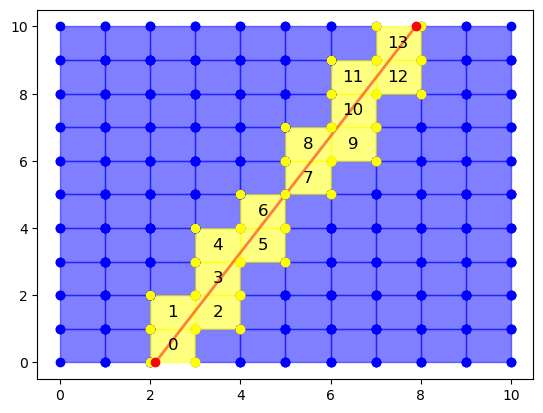

In [169]:
test_intersecting_cells(0, np.pi / 3)

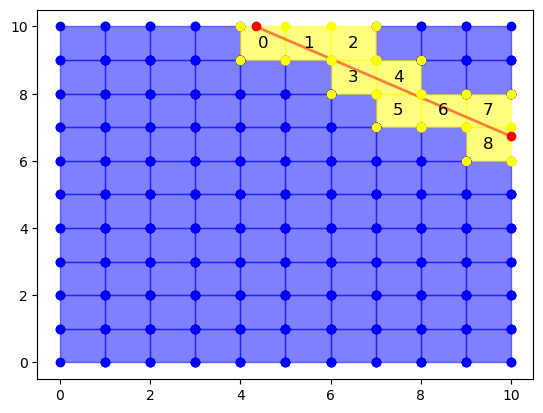

In [170]:
test_intersecting_cells(-4, -np.pi / 6)

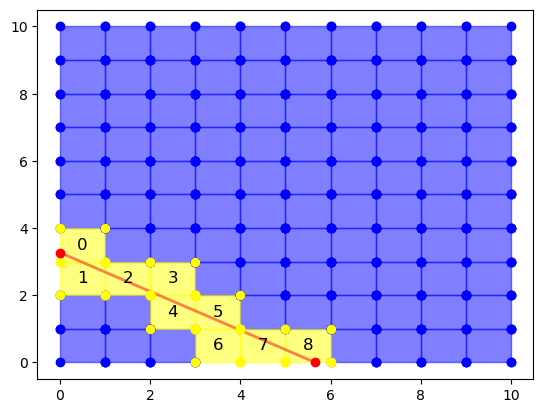

In [171]:
test_intersecting_cells(4, -np.pi / 6)

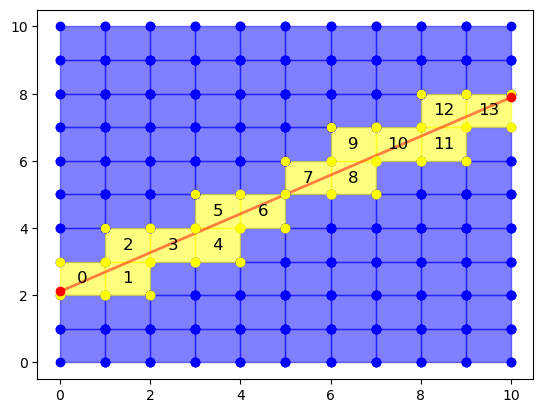

In [172]:
test_intersecting_cells(0, np.pi / 6)

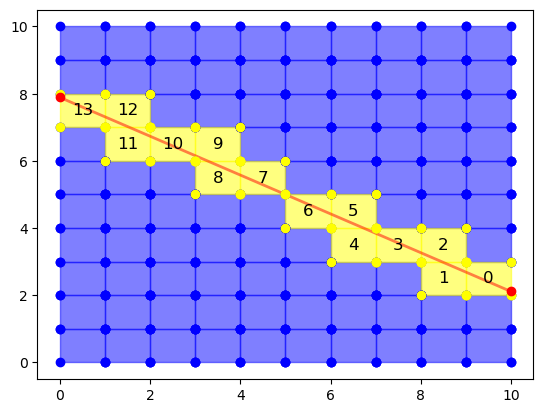

In [173]:
test_intersecting_cells(0, 5 * np.pi / 6)

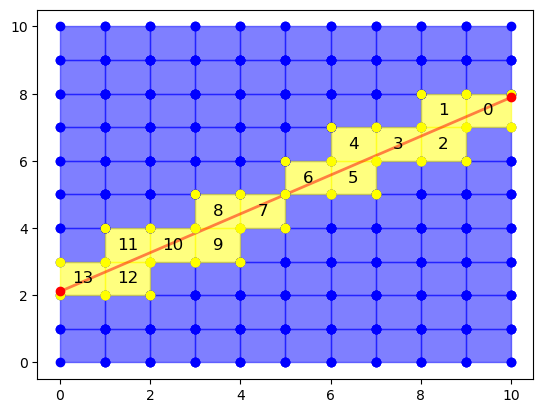

In [174]:
test_intersecting_cells(0, 7 * np.pi / 6)

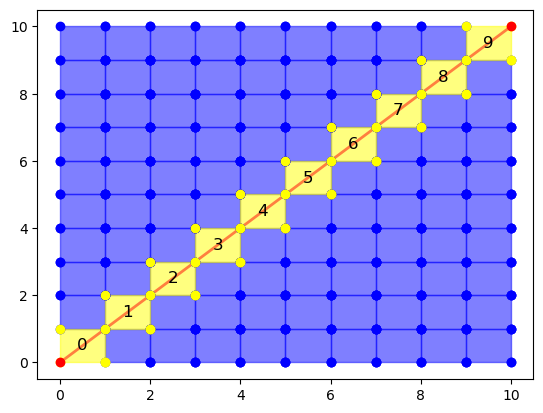

In [175]:
test_intersecting_cells(0, np.pi / 4)

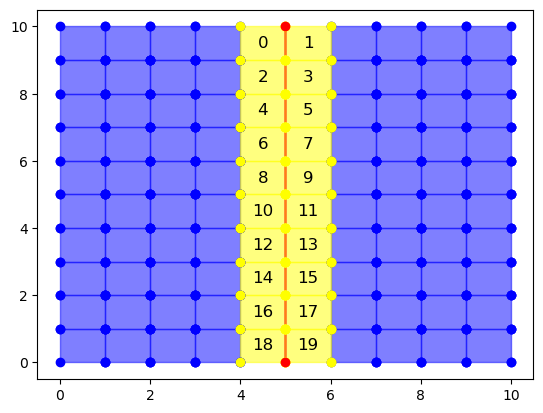

In [176]:
test_intersecting_cells(0, np.pi/2)
